<a href="https://colab.research.google.com/github/fmakkawi/Data201/blob/main/Project_1data201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Setup & Data Upload ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Colab helper for file upload/download
from google.colab import files

print("👉 Click the 'Choose Files' button and upload your WA EV CSV now.")
uploaded = files.upload()  # select the EV CSV here

# Use whatever filename you uploaded (take the first file)
csv_path = list(uploaded.keys())[0]
print("Loaded file:", csv_path)

# Read the CSV
df = pd.read_csv(csv_path, low_memory=False)
df.shape


👉 Click the 'Choose Files' button and upload your WA EV CSV now.


Saving Electric_Vehicle_Population_Data.csv to Electric_Vehicle_Population_Data.csv
Loaded file: Electric_Vehicle_Population_Data.csv


(264628, 17)

In [2]:
# --- Wrangling ---
def to_snake(s):
    return (
        str(s).strip()
        .replace(" ", "_").replace("/", "_").replace("-", "_")
        .replace("(", "").replace(")", "").replace("__", "_").lower()
    )

# Rename columns to snake_case (easier coding)
df.columns = [to_snake(c) for c in df.columns]

# Drop duplicate rows
df = df.drop_duplicates()

# Convert numeric columns
for c in ["model_year", "electric_range", "base_msrp"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Clean text columns
for c in ["make", "model", "electric_vehicle_type", "cafv_eligibility", "county", "city", "electric_utility", "state"]:
    if c in df.columns and df[c].dtype == object:
        df[c] = df[c].astype(str).str.strip()

# Derived columns
df["ev_type"] = df.get("electric_vehicle_type", pd.Series(index=df.index, dtype='object')).astype(str).str.upper().str.extract(r"(BEV|PHEV)", expand=False)
df["make_clean"] = df.get("make", pd.Series(index=df.index, dtype='object')).astype(str).str.upper()

# Fix invalid model years
from datetime import datetime
current_year = datetime.now().year
if "model_year" in df.columns:
    df.loc[(df["model_year"] < 1990) | (df["model_year"] > current_year + 1), "model_year"] = np.nan

df.shape, df.head()


((264628, 19),
      vin_1_10     county     city state  postal_code  model_year    make  \
 0  WA1E2AFY8R   Thurston  Olympia    WA      98512.0      2024.0    AUDI   
 1  WAUUPBFF4J     Yakima   Wapato    WA      98951.0      2018.0    AUDI   
 2  1N4AZ0CP0F       King  Seattle    WA      98125.0      2015.0  NISSAN   
 3  WA1VAAGE5K       King     Kent    WA      98031.0      2019.0    AUDI   
 4  7SAXCAE57N  Snohomish  Bothell    WA      98021.0      2022.0   TESLA   
 
      model                   electric_vehicle_type  \
 0     Q5 E  Plug-in Hybrid Electric Vehicle (PHEV)   
 1       A3  Plug-in Hybrid Electric Vehicle (PHEV)   
 2     LEAF          Battery Electric Vehicle (BEV)   
 3   E-TRON          Battery Electric Vehicle (BEV)   
 4  MODEL X          Battery Electric Vehicle (BEV)   
 
      clean_alternative_fuel_vehicle_cafv_eligibility  electric_range  \
 0              Not eligible due to low battery range            23.0   
 1              Not eligible due to low bat

In [3]:
# --- EDA Summaries ---
summaries = {}
if "model_year" in df.columns:
    summaries["vehicles_by_year"] = df["model_year"].value_counts(dropna=False).sort_index()
if "make_clean" in df.columns:
    summaries["top_makes"] = df["make_clean"].value_counts().head(15)
if "electric_range" in df.columns:
    summaries["electric_range_desc"] = df["electric_range"].describe()

for k, v in summaries.items():
    print(f"\n=== {k} ===")
    print(v)



=== vehicles_by_year ===
model_year
1999.0        2
2000.0        8
2002.0        1
2003.0        1
2008.0       20
2010.0       22
2011.0      622
2012.0     1438
2013.0     4061
2014.0     3293
2015.0     4532
2016.0     5203
2017.0     8668
2018.0    14323
2019.0    10935
2020.0    12213
2021.0    20774
2022.0    29400
2023.0    60157
2024.0    49234
2025.0    32674
2026.0     7047
Name: count, dtype: int64

=== top_makes ===
make_clean
TESLA            108633
CHEVROLET         19051
NISSAN            16177
FORD              14347
KIA               13183
TOYOTA            11022
BMW               10882
HYUNDAI            9278
RIVIAN             8118
VOLKSWAGEN         7074
VOLVO              6899
JEEP               6811
AUDI               5524
CHRYSLER           3874
MERCEDES-BENZ      3081
Name: count, dtype: int64

=== electric_range_desc ===
count    264624.000000
mean         41.713159
std          80.377977
min           0.000000
25%           0.000000
50%           0.000000
75

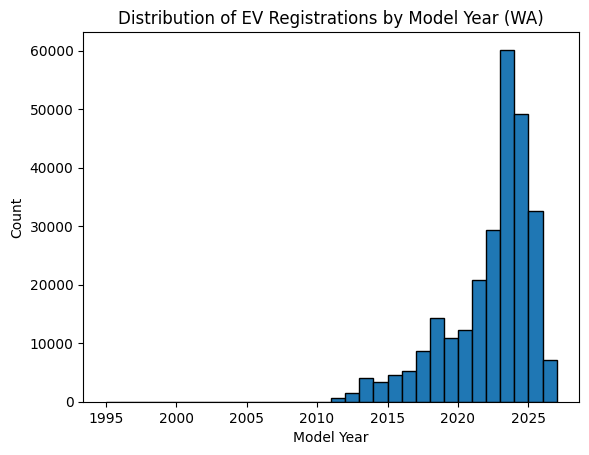

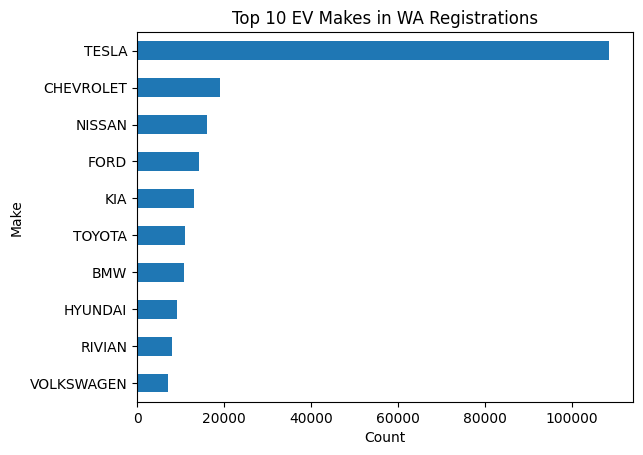

/tmp/ipython-input-2017577506.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, vert=True)


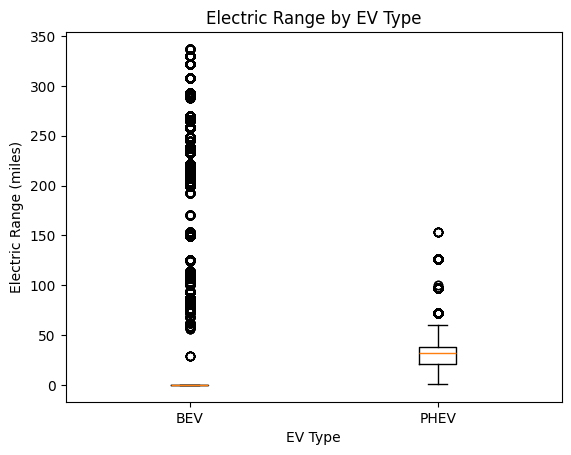

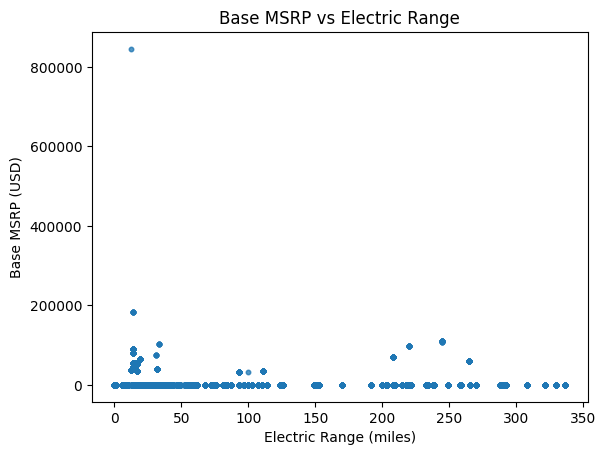

In [4]:
# --- Matplotlib visualizations ---
import os
os.makedirs("figs", exist_ok=True)

# Histogram — Model Year
if "model_year" in df.columns and df["model_year"].notna().sum() > 0:
    plt.figure()
    bins = range(1995, int(df["model_year"].max()) + 2, 1)
    df["model_year"].dropna().astype(int).plot(kind="hist", bins=bins, edgecolor="black")
    plt.title("Distribution of EV Registrations by Model Year (WA)")
    plt.xlabel("Model Year")
    plt.ylabel("Count")
    plt.show()

# Bar — Top 10 Makes
if "make_clean" in df.columns and df["make_clean"].notna().sum() > 0:
    top10 = df["make_clean"].value_counts().head(10)
    plt.figure()
    top10.sort_values(ascending=True).plot(kind="barh")
    plt.title("Top 10 EV Makes in WA Registrations")
    plt.xlabel("Count")
    plt.ylabel("Make")
    plt.show()

# Box — Electric Range by EV Type
if "electric_range" in df.columns and "ev_type" in df.columns and df["electric_range"].notna().sum() > 0:
    plt.figure()
    groups, labels = [], []
    for label in ["BEV", "PHEV"]:
        mask = (df["ev_type"] == label) & df["electric_range"].notna()
        if mask.any():
            groups.append(df.loc[mask, "electric_range"].astype(float).values)
            labels.append(label)
    if groups:
        plt.boxplot(groups, labels=labels, vert=True)
        plt.title("Electric Range by EV Type")
        plt.xlabel("EV Type")
        plt.ylabel("Electric Range (miles)")
        plt.show()

# Scatter — MSRP vs Electric Range
if "base_msrp" in df.columns and "electric_range" in df.columns:
    mask = df["base_msrp"].notna() & df["electric_range"].notna()
    if mask.sum() > 0:
        plt.figure()
        plt.scatter(df.loc[mask, "electric_range"], df.loc[mask, "base_msrp"], s=10, alpha=0.5)
        plt.title("Base MSRP vs Electric Range")
        plt.xlabel("Electric Range (miles)")
        plt.ylabel("Base MSRP (USD)")
        plt.show()


In [5]:
# --- 10% random sample + bootstrap CI for median ---
np.random.seed(42)
sample_df = df.sample(frac=0.10, random_state=42)

def bootstrap_median_ci(x, reps=5000, ci=95):
    x = np.asarray(x).astype(float)
    n = len(x)
    boot = np.empty(reps)
    for b in range(reps):
        idx = np.random.randint(0, n, n)
        boot[b] = np.median(x[idx])
    low = np.percentile(boot, (100-ci)/2)
    high = np.percentile(boot, 100 - (100-ci)/2)
    return float(np.median(x)), float(low), float(high), reps

mask = sample_df["electric_range"].notna() & (sample_df["electric_range"] > 0)
x = sample_df.loc[mask, "electric_range"].values

median, ci_low, ci_high, B = bootstrap_median_ci(x)
print(f"Median electric range (miles): {median}")
print(f"95% CI from bootstrap ({B} reps): [{ci_low:.1f}, {ci_high:.1f}]")
print(f"Sample size: {len(x)}")


Median electric range (miles): 53.0
95% CI from bootstrap (5000 reps): [53.0, 53.0]
Sample size: 10143
